# 决策树

本实验中实现的决策树分为三种：

1. 样本特征为离散值、标签为离散值的分类决策树，在 melon 数据集上训练；
2. 样本特征为连续值、标签为离散值的分类决策树，iris 数据集和 cancer 数据集上训练；
3. 样本特征和标签均为连续值的回归决策树，在 machine 数据集和 mark 数据集上训练。

三种决策树的划分选择、叶结点代表的标记值、数据的类型、生成决策树的算法有所区别。三种决策树对应本目录下的 `discrete_decision_tree.py`、`classification_decision_tree.py`、`regression_decision_tree.py`。

## 文件结构

```
backpropagation
├── dataset
│   ├── melon.txt
│   ├── iris.txt
│   ├── cancer.txt
│   ├── machine.csv
│   └── Student_Marks.csv
├── decision_tree.ipynb
├── discrete_decision_tree.py
├── classification_decision_tree.py
└── regression_decision_tree.py
```

## 实验环境

- Python 3.10.6
- `numpy==1.24.3`
- `matplotlib==3.7.1`

# 在 melon 数据集上训练特征离散的分类决策树

在该部分实现了信息增益、增益率、基尼指数三种划分选择方式，并选择了基尼指数生成决策树。

In [1]:
import math
import os
import numpy as np


def load_data(file: str, sep: str, has_headers: bool, shuffle: bool=True):
    """
    加载字符串数据、用于分类决策树。
    input:
        file: 数据文件路径。
        sep: 文件分隔符。
        has_headers: 表示数据文件是否包含表头。
    output:
        X: 每行表示一个样本、每列表示一个样本特征的矩阵。
        Y: 每行表示一个样本标签、列数为 1 的向量。
        headers: 表头。
        shuffle: 表示是否打乱数据集。默认为 True。
    """
    with open(
            file=file,
            mode='r', encoding="utf-8") as f:
        if has_headers:
            headers = f.readline().strip().split(sep=sep)
        data = [sample.strip().split(sep=sep)
            for sample in f.readlines()]
    
    if shuffle:
        np.random.shuffle(data)

    X = [sample[:-1] for sample in data]
    Y = [sample[-1] for sample in data]

    if has_headers:
        return X, Y, headers
    else:
        return X, Y


def get_label_space(Y: list) -> list:
    """
    标记空间。
    """
    return list(set(Y))


def get_sample_space(X: list) -> dict:
    """
    样本空间。
    """
    m = len(X)
    d = len(X[0])
    features = dict()
    for i in range(d):
        features_i = []
        for k in range(m):
            if X[k][i] not in features_i:
                features_i.append(X[k][i])
        features[i] = features_i
    return features


def information_entropy(Y: list) -> float:
    """
    信息熵。
    """
    labels = get_label_space(Y=Y)
    m = len(Y)
    ent = 0
    for label in labels:
        p = Y.count(label) / m
        ent -= p * math.log(p, 2)
    return ent


def information_gain(X, Y) -> list:
    """
    信息增益。
    """
    m = len(X)
    d = len(X[0])
    overall_entropy = information_entropy(Y=Y)
    sample_space = get_sample_space(X=X)
    gain = d * [overall_entropy]
    for i in range(d):
        for v in sample_space[i]:
            y = []
            for k in range(m):
                if X[k][i] == v:
                    y.append(Y[k])
            gain[i] -= len(y) * information_entropy(Y=y) / m
    return gain


def gain_ratio(X, Y) -> list:
    """
    信息增益率。
    """
    m = len(X)
    d = len(X[0])
    intrinsic_value = d * [0]
    overall_entropy = information_entropy(Y=Y)
    sample_space = get_sample_space(X=X)
    gain = d * [overall_entropy]
    for i in range(d):
        for v in sample_space[i]:
            y = []
            for k in range(m):
                if X[k][i] == v:
                    y.append(Y[k])
            intrinsic_value[i] -= len(y) * math.log2(len(y) / m) / m
            gain[i] -= len(y) * information_entropy(Y=y) / m
        gain[i] /= intrinsic_value[i] + 1e-8
    return gain


def gini(Y):
    """
    基尼值。
    """
    labels = get_label_space(Y=Y)
    m = len(Y)
    gini_value = 1
    for label in labels:
        p = Y.count(label) / m
        gini_value -= p ** 2
    return gini_value


def gini_index(X, Y):
    """
    基尼指数。
    """
    m = len(X)
    d = len(X[0])
    gini_index_value = d * [0]
    sample_space = get_sample_space(X=X)
    for i in range(d):
        for v in sample_space[i]:
            x, y = [], []
            for k in range(m):
                if X[k][i] == v:
                    x.append(X[k])
                    y.append(Y[k])
            gini_index_value[i] -= len(y) * gini(Y=y) / m
    return gini_index_value


def get_partition_feature(gain, disabled_features) -> int:
    """
    选择最优划分属性。
    input:
        gain: 信息增益、或其他划分准则。
        disabled_features: 辅助变量、记录已经使用过的划分属性。
    output:
        max_gain_index: 最优划分属性。
    """
    d = len(gain)
    max_gain_index = 0
    while max_gain_index in disabled_features:
        max_gain_index += 1
    for i in range(max_gain_index + 1, d):
        if i not in disabled_features and gain[i] > gain[max_gain_index]:
            max_gain_index = i
    return max_gain_index


def get_most_label(Y: list):
    """
    返回标记集合中数目最多的类别。
    """
    label_space = get_label_space(Y=Y)
    most_label = label_space[0]
    most_label_count = Y.count(most_label)
    for label in label_space[1:]:
        label_count = Y.count(label)
        if label_count > most_label_count:
            most_label = label
            most_label_count = label_count
    return most_label


# tree: (class_or_feature, {feature_value: subtree})
# class: Any, feature: int, feature_value: Any
def build_tree(X, Y, disabled_features = []) -> tuple:
    """
    生成分类决策树。
    input:
        X: 样本集合。
        Y: 标记集合。
        disabled_features: 辅助变量、记录已经使用过的划分属性。
    output:
        形如 tree = (class_or_feature, {feature_value: subtree}) 的决策树。
        若 tree[1] 为空则 tree[0] 为分类标记。
        若 tree[1] 不为空则 tree[0] 为最优划分属性、tree[1] 为一个字典。
        tree[1] 的 key 为最优划分属性对应的取值、value 为该取值下的分支子树。
    """
    # 若 D 中样本全为一类 C，
    # 则将 node 标记为 C 类叶结点
    label_space = get_label_space(Y=Y)
    if len(label_space) == 1:
        return label_space[0], dict()

    # 若 A 为空集，或 X 在 A 上取值相同
    # 则将 node 标记叶结点，
    # 其类别为 Y 中数量最多的类
    sample_space = get_sample_space(X=X)
    all_feature_same = True
    for feature in sample_space.keys():
        if feature not in disabled_features and len(sample_space[feature]) > 1:
            all_feature_same = False
            break
    if all_feature_same:
        return get_most_label(Y=Y), dict()

    # 从 A 中选择最优划分属性（此处基于基尼系数进行划分），
    # 将该属性记为 a
    gain = gini_index(X=X, Y=Y)
    partition = get_partition_feature(gain=gain, disabled_features=disabled_features)
    disabled_features += [partition]
    subnodes = dict()

    # 对于 a 的每一个属性值 v，
    # 为 node 生成一个分支
    # 令 D_v 表示 D 中在 a 上取值为 v 的子集
    for feature_value in sample_space[partition]:
        x, y = [], []
        m = len(X)
        for i in range(m):
            if X[i][partition] == feature_value:
                x.append(X[i])
                y.append(Y[i])
        # 若 D_v 为空集，
        # 则将分支结点标记为叶结点，
        # 其类别为 Y 中数量最多的类
        if y == []:
            subnodes[feature_value] = get_most_label(Y=Y)
        # 在 D_v 上根据 A - a 生成子决策树，连接到该分支上
        else:
            subnodes[feature_value] = build_tree(X=x, Y=y, disabled_features=disabled_features)
    return partition, subnodes


def pretty_show(tree, headers = lambda x: x, level = 0):
    """
    打印分类决策树。
    """
    if tree[1] == dict():
        print(level * '\t' + 'label: ' + tree[0])
    else:
        print(level * '\t' + 'partition feature: {}'.format(headers(tree[0])))
        for feature_value in tree[1].keys():
            print(level * '\t' + '{}'.format(feature_value))
            pretty_show(tree=tree[1][feature_value], headers=headers, level=level+1)


def predict(tree, X):
    """
    根据输入数据进行预测。
    input:
        tree: 决策树。
        X: 测试样本集合。
    output:
        对测试样本的预测值。
    """
    def __predict(tree, X):
        if tree[1] == dict():
            return tree[0]
        else:
            return __predict(tree=tree[1][X[tree[0]]], X=X)

    m = len(X)
    return [__predict(tree=tree, X=X[k]) for k in range(m)]


def test(prediction, Y):
    """
    根据对测试数据预测值和测试数据的真实值计算预测正确率。
    input:
        prediction: 预测值。
        Y: 真实值。
    """
    m = len(Y)
    right = 0
    error = 0
    for k in range(m):
        if prediction[k] == Y[k]:
            right += 1
        else:
            error += 1
    print("Right: {}, error: {}, right rate: {}".format(
        right, error, 1 if m == 0 else right / (right + error)))


X, Y, headers = load_data(
    file=os.path.join('dataset', 'melon.txt'),
    sep=' ', has_headers=True)
tree = build_tree(X=X, Y=Y)
pretty_show(tree, headers=lambda x: headers[x])
prediction = predict(tree=tree, X=X)
test(prediction=prediction, Y=Y)

partition feature: 纹理
清晰
	partition feature: 根蒂
	蜷缩
		label: 是
	稍蜷
		partition feature: 色泽
		乌黑
			partition feature: 触感
			硬滑
				label: 是
			软粘
				label: 否
		青绿
			label: 是
	硬挺
		label: 否
稍糊
	partition feature: 敲声
	沉闷
		label: 否
	浊响
		partition feature: 脐部
		凹陷
			label: 否
		稍凹
			label: 是
模糊
	label: 否
Right: 17, error: 0, right rate: 1.0


# 在 iris 数据集和 cancer 数据集上训练特征连续的分类决策树

In [2]:
import numpy as np
import os


class Node:
    def __init__(
        self, is_leaf, 
        feature=None,
        value=None,
        label=None,
        left=None,
        right=None
    ) -> None:
        self.is_leaf = is_leaf
        self.feature = feature
        self.value = value
        self.label = label
        self.left = left
        self.right = right


def load_data(file, sep, training_number, has_headers: bool, shuffle: bool=True):
    """
    从文件中加载数据。要求数据文件每行包含一个样例且每行最后一个数据为样例标签。
    input:
        file: 数据文件路径。
        sep: 文件中每个特征的分隔符。
        training_number: 训练样本的个数、剩余的被分为测试样本。
        has_headers: 表示数据文件是否包含表头。
    output:
        X: 每行表示一个样本、每列表示一个样本特征的矩阵。
        Y: 每行表示一个样本标签、列数为 1 的向量。
        headers: 表头。
        shuffle: 表示是否打乱数据集。默认为 True。
    """
    with open(
            file=file,
            mode='r') as f:
        if has_headers:
            headers = f.readline().strip().split(sep=sep)
        data = np.array([[np.float64(feature)
            for feature in sample.strip().split(sep=sep)]
            for sample in f.readlines()],
            dtype=np.float64)
    
    if shuffle:
        np.random.shuffle(data)

    X = data[:, :-1]
    Y = data[:, -1]

    X_training = X[:training_number, :]
    Y_training = Y[:training_number]
    X_test = X[training_number:, :]
    Y_test = Y[training_number:]

    if has_headers:
        return X_training, Y_training, X_test, Y_test, headers
    else:
        return X_training, Y_training, X_test, Y_test


def get_label_space(Y) -> np.matrix:
    """
    标记空间。
    """
    return np.unique(Y)


def information_entropy(Y: np.matrix) -> np.float64:
    """
    信息熵。
    """
    labels = get_label_space(Y=Y)
    m = len(Y)
    ent = np.float64(0.)
    for label in labels:
        p = np.count_nonzero(Y == label) / m
        ent -= p * np.log2(p)
    return ent


def get_most_label(Y: list):
    """
    返回标记集合中数目最多的类别。
    """
    label_space = get_label_space(Y=Y)
    most_label = label_space[0]
    most_label_count = np.count_nonzero(Y == most_label)
    for label in label_space[1:]:
        label_count = most_label_count = np.count_nonzero(Y == label)
        if label_count > most_label_count:
            most_label = label
            most_label_count = label_count
    return most_label


def split(X, Y, feature, value):
    """
    把数据集根据特征 feature 的取值进行划分、
    分为不大于 value 和大于 value 的两部分。
    input:
        X: 样本集合。
        Y: 标记集合。
        feature: 进行划分依赖的特征。
        value: 对应特征上的分界值。
    """
    left = (X[:,feature] <= value)
    right = (X[:,feature] > value)
    return X[left], X[right], Y[left], Y[right]


def get_partition(X, Y):
    """
    计算最佳划分特征及最佳划分点。
    input:
        X: 样本集合。
        Y: 标记集合。
    output:
        best_entropy: 最佳划分时的信息熵。
        best_feature: 最佳划分特征。
        best_value: 最佳划分的值。
    """
    best_entropy = np.inf
    best_feature = -1
    best_value = -1
    d = X.shape[1]
    m = len(X)

    for i in range(d):
        sorted_index = np.argsort(X[:, i])
        for k in range(1, m):
            if X[sorted_index[k], i] != X[sorted_index[k - 1], i]:
                mid = (X[sorted_index[k], i] + X[sorted_index[k-1], i]) / 2
                X_left, X_right, Y_left, Y_right = split(X, Y, i, mid)

                p_left = len(X_left) / len(X)
                p_right = len(X_right) / len(X)

                ent = p_left * information_entropy(Y_left) + p_right * information_entropy(Y_right)
                if ent < best_entropy:
                    best_entropy = ent
                    best_feature = i
                    best_value = mid

    return best_entropy, best_feature, best_value


def build_tree(X, Y) -> tuple:
    """
    生成分类决策树。
    input:
        X: 样本集合。
        Y: 标记集合。
    output:
        决策树的根节点。
    """
    label_space = get_label_space(Y)
    if len(label_space) == 1:
        return Node(is_leaf=True, label=label_space[0])

    entropy, feature, value = get_partition(X=X, Y=Y)
    if entropy == 0:
        return Node(is_leaf=True, label=get_most_label(Y=Y))

    X_left, X_right, Y_left, Y_right = split(X=X, Y=Y, feature=feature, value=value)
    return Node(
        is_leaf=False,
        feature=feature,
        value=value,
        left=build_tree(X=X_left, Y=Y_left),
        right=build_tree(X=X_right, Y=Y_right))


def pretty_show(tree: Node, headers=lambda x: x, level: int=0):
    """
    打印分类决策树。
    """
    if tree.is_leaf:
        print(level * '\t' + 'label: {}'.format(tree.label))
    else:
        print(level * '\t' + 'partition feature: {}'.format(headers(tree.feature)))
        print(level * '\t' + 'If value <= {}'.format(tree.value))
        pretty_show(tree=tree.left, headers=headers, level=level+1)
        print(level * '\t' + 'If value > {}'.format(tree.value))
        pretty_show(tree=tree.right, headers=headers, level=level+1)


def predict(tree: Node, X: np.matrix):
    """
    根据输入数据进行预测。
    input:
        tree: 决策树的根节点。
        X: 测试样本集合。
    output:
        对测试样本的预测值。
    """
    def __predict(__tree: Node, __X):
        if __tree.is_leaf:
            return __tree.label
        
        __feature = __tree.feature
        __value = __tree.value
        if __X[__feature] <= __value:
            return __predict(__tree.left, __X)
        else:
            return __predict(__tree.right, __X)

    return np.array([__predict(tree, X[k, :]) for k in range(X.shape[0])], dtype=np.float64)


def test(prediction, Y):
    """
    根据对测试数据预测值和测试数据的真实值计算预测正确率。
    input:
        prediction: 预测值。
        Y: 真实值。
    """
    m = Y.shape[0]
    right = 0
    error = 0
    for k in range(m):
        if prediction[k] == Y[k]:
            right += 1
        else:
            error += 1
    print("Right: {}, error: {}, right rate: {}".format(
        right, error, 1 if m == 0 else right / (right + error)))


iris_X_training, iris_Y_training, iris_X_test, iris_Y_test = load_data(
    file=os.path.join('dataset', 'iris.txt'),
    sep=',',
    training_number=100,
    has_headers=False)

iris_tree = build_tree(X=iris_X_training, Y=iris_Y_training)
print("============== iris tree ==============")
pretty_show(iris_tree)
iris_prediction = predict(iris_tree, iris_X_test)
test(prediction=iris_prediction, Y=iris_Y_test)

cancer_X_training, cancer_Y_training, cancer_X_test, cancer_Y_test = load_data(
    file=os.path.join('dataset', 'cancer.txt'),
    sep='\t',
    training_number=450,
    has_headers=False)

cancer_tree = build_tree(X=cancer_X_training, Y=cancer_Y_training)
print("============== cancer tree ==============")
pretty_show(cancer_tree)
cancer_prediction = predict(cancer_tree, cancer_X_test)
test(cancer_prediction, cancer_Y_test)

============== iris tree ==============
partition feature: 2
If value <= 2.45
	label: 0.0
If value > 2.45
	partition feature: 2
	If value <= 4.85
		partition feature: 3
		If value <= 1.65
			label: 1.0
		If value > 1.65
			label: 1.0
	If value > 4.85
		partition feature: 2
		If value <= 4.95
			label: 1.0
		If value > 4.95
			label: 2.0
Right: 46, error: 4, right rate: 0.92
============== cancer tree ==============
partition feature: 22
If value <= 105.15
	partition feature: 26
	If value <= 0.38415
		partition feature: 13
		If value <= 47.035
			partition feature: 21
			If value <= 30.145
				label: 1.0
			If value > 30.145
				partition feature: 27
				If value <= 0.09229000000000001
					label: 1.0
				If value > 0.09229000000000001
					label: 0.0
		If value > 47.035
			label: 0.0
	If value > 0.38415
		partition feature: 4
		If value <= 0.10114000000000001
			label: 1.0
		If value > 0.10114000000000001
			label: 0.0
If value > 105.15
	partition feature: 27
	If value <= 0.15075
		par

# 在 machine 数据集和 mark 数据集上训练特征连续的回归决策树

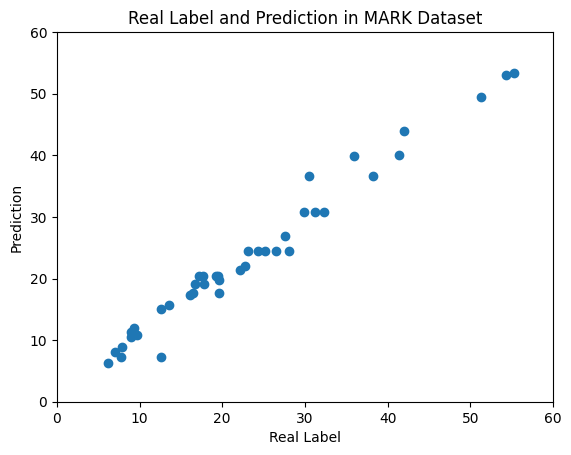

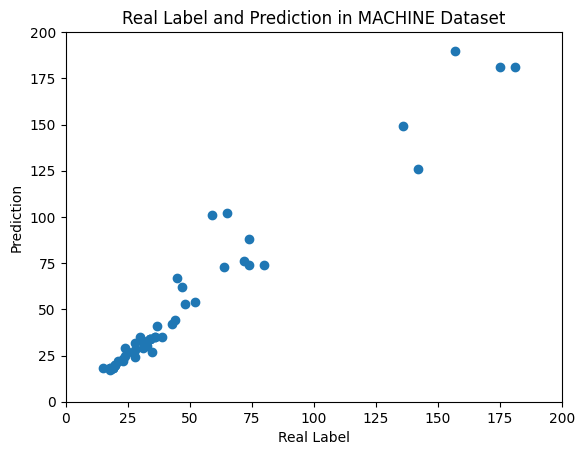

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt


class Node:
    def __init__(
        self, is_leaf, 
        feature=None,
        value=None,
        label=None,
        left=None,
        right=None
    ) -> None:
        self.is_leaf = is_leaf
        self.feature = feature
        self.value = value
        self.label = label
        self.left = left
        self.right = right


def load_data(file, sep, training_number, has_headers: bool, shuffle: bool=True):
    """
    从文件中加载数据。要求数据文件每行包含一个样例且每行最后一个数据为样例标签。
    input:
        file: 数据文件路径。
        sep: 文件中每个特征的分隔符。
        training_number: 训练样本的个数、剩余的被分为测试样本。
        has_headers: 表示数据文件是否包含表头。
        shuffle: 表示是否打乱数据集。默认为 True。
    output:
        X: 每行表示一个样本、每列表示一个样本特征的矩阵。
        Y: 每行表示一个样本标签、列数为 1 的向量。
        headers: 表头。
    """
    with open(
            file=file,
            mode='r') as f:
        if has_headers:
            headers = f.readline().strip().split(sep=sep)
        data = np.array([[np.float64(feature)
            for feature in sample.strip().split(sep=sep)]
            for sample in f.readlines()],
            dtype=np.float64)

    X = data[:, :-1]
    Y = data[:, -1]

    if shuffle:
        np.random.shuffle(data)

    X_training = X[:training_number, :]
    Y_training = Y[:training_number]
    X_test = X[training_number:, :]
    Y_test = Y[training_number:]

    if not has_headers:
        return X_training, Y_training, X_test, Y_test
    else:
        return X_training, Y_training, X_test, Y_test, headers


def MSE(prediction, Y):
    """
    平方误差。用于确定最优划分点、评价回归树的性能。
    """
    return np.mean(np.square(prediction - Y))


def split(X, Y, feature, value):
    """
    把数据集根据特征 feature 的取值进行划分、
    分为不大于 value 和大于 value 的两部分。
    input:
        X: 样本集合。
        Y: 标记集合。
        feature: 进行划分依赖的特征。
        value: 对应特征上的分界值。
    """
    left = (X[:,feature] <= value)
    right = (X[:,feature] > value)
    return X[left], X[right], Y[left], Y[right]


def get_partition(X, Y):
    """
    计算最佳划分特征及最佳划分点。
    input:
        X: 样本集合。
        Y: 标记集合。
    output:
        best_feature: 最佳划分特征。
        best_value: 最佳划分的值。
    """
    best_loss = np.inf
    best_feature = None
    best_value = None
    d = X.shape[1]
    m = len(X)

    for i in range(d):
        sorted_index = np.argsort(X[:, i])
        for k in range(1, m):
            if X[sorted_index[k], i] != X[sorted_index[k - 1], i]:
                _, _, Y_left, Y_right = split(X, Y, i, X[sorted_index[k - 1], i])

                assert(len(Y_left) != 0 and len(Y_right) != 0)
                prediction_left = np.mean(Y_left)
                prediction_right = np.mean(Y_right)
                loss = MSE(prediction_left, Y_left) + MSE(prediction_right, Y_right)
                if loss < best_loss:
                    best_loss = loss
                    best_feature = i
                    best_value = X[sorted_index[k - 1], i]

    return best_feature, best_value


def build_tree(X, Y, level=0) -> tuple:
    """
    D: 训练集
    A: 属性集
    X: 训练集样本
    Y: 训练集样本标签
    """
    feature, value = get_partition(X=X, Y=Y)
    if feature is None:
        return Node(is_leaf=True, label=np.mean(Y))
    X_left, X_right, Y_left, Y_right = split(X=X, Y=Y, feature=feature, value=value)
    if len(Y_left) == 0:
        return Node(is_leaf=True, label=np.mean(Y_right))
    elif len(Y_right) == 0:
        return Node(is_leaf=True, label=np.mean(Y_left))

    return Node(
        is_leaf=False,
        feature=feature,
        value=value,
        left=build_tree(X=X_left, Y=Y_left, level=level+1),
        right=build_tree(X=X_right, Y=Y_right, level=level+1))


def pretty_show(tree: Node, headers=lambda x: x, level: int=0):
    """
    打印回归决策树。（不推荐使用）
    """
    if tree.is_leaf:
        print(level * '  ' + 'label: {}'.format(tree.label))
    else:
        print(level * '  ' + 'partition feature: {}'.format(headers(tree.feature)))
        print(level * '  ' + 'If value <= {}'.format(tree.value))
        pretty_show(tree=tree.left, headers=headers, level=level+1)
        print(level * '  ' + 'If value > {}'.format(tree.value))
        pretty_show(tree=tree.right, headers=headers, level=level+1)


def predict(tree: Node, X: np.matrix):
    """
    根据输入数据进行预测。
    input:
        tree: 决策树的根节点。
        X: 测试样本集合。
    output:
        对测试样本的预测值。
    """
    def __predict(__tree: Node, __X):
        if __tree.is_leaf:
            return __tree.label
        
        __feature = __tree.feature
        __value = __tree.value
        if __X[__feature] <= __value:
            return __predict(__tree.left, __X)
        else:
            return __predict(__tree.right, __X)

    return np.array([__predict(tree, X[k, :]) for k in range(X.shape[0])], dtype=np.float64)


mark_X_training, mark_Y_training, mark_X_test, mark_Y_test, mark_headers = load_data(
    file=os.path.join('dataset', 'Student_Marks.csv'),
    sep=',',
    training_number=60,
    has_headers=True)

mark_tree = build_tree(X=mark_X_training, Y=mark_Y_training)
mark_prediction = predict(mark_tree, mark_X_test)

plt.figure()
plt.title("Real Label and Prediction in MARK Dataset")
plt.scatter(mark_Y_test, mark_prediction)
plt.xlabel("Real Label")
plt.ylabel("Prediction")
plt.xlim(0, 60)
plt.ylim(0, 60)
plt.show()


machine_X_training, machine_Y_training, machine_X_test, machine_Y_test = load_data(
    file=os.path.join('dataset', 'machine.csv'),
    sep=',',
    training_number=150,
    has_headers=False
)

machine_tree = build_tree(X=machine_X_training, Y=machine_Y_training)
machine_prediction = predict(machine_tree, machine_X_test)

plt.figure()
plt.title("Real Label and Prediction in MACHINE Dataset")
plt.scatter(machine_Y_test, machine_prediction)
plt.xlabel("Real Label")
plt.ylabel("Prediction")
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.show()


# 实验结果说明

- 在 melon 数据集的样本数量少，能够得到训练误差为 0 的决策树。其树结构通过打印的方式展示。
- 在 iris 数据集和 cancer 数据集上训练的决策树深度较浅、分支较少，因此也通过打印的方式展示树结构。通过对测试集预测的正确率来评价分类回归树的性能。
- 在 machine 数据集和 mark 数据集上训练的决策树深度很深、分支很多，不适合打印树结构。为了展示其分类效果绘制了测试集中真实标记与预测值的散点图。散点图越接近直线 `y = x` 则说明训练效果越好。从绘制的图像中可以看到，预测值与真实值比较接近，说明回归决策树具有比较好的性能。